In [1]:
import networkx as nx 
import matplotlib.pyplot as plt 
import numpy as np
import EoN

In [2]:
N = 10 ** 5
G = nx.barabasi_albert_graph(N, 5)

tmax = 20 
iterations = 5  #run 5 simulations
tau = 0.1           #transmission rate
gamma = 1.0    #recovery rate
rho = 0.005      #random fraction initially infected



In [69]:
def run_until_time(G, xmission, recovery, rho, tmax, copy_graph=True):
    """ Runs a basic SIR (cont time) model on graph G 
        with fixed transmission/recovery_rate.
    ARGS:
        G: Networkx graph object
        xmission: float - transmission rate 
        recovery: float - recovery rate 
        rho:  float - fraction of nodes which are randomly 
                initially infected 
        tmax : float - time we run until 
    RETURNS:
        G': networx graph with all IR nodes/edges removed 
        summary: Infection_Summary object which summarizes the run 
                 *** ATTACHES THE .tmax attribute to this object ***
    """
    summary = EoN.fast_SIR(G, xmission, recovery, rho=rho, tmax=tmax, return_full_data=True)
    setattr(summary, 'tmax', tmax)
    # Now collect only the infected/recovered nodes 
    status_dict = _split_summary(summary)
    if copy_graph: 
        G = G.copy()
    if tmax > 0.0:
        G.remove_nodes_from(status_dict.get('I', []))
        G.remove_nodes_from(status_dict.get('R', []))
    
    return G, summary


def _split_summary(summary_obj):
    sort_dict = {} 
    for k, v in summary_obj.get_statuses(time=summary_obj.tmax).items():
        sort_dict[v] = sort_dict.get(v, [])
        sort_dict[v].append(k)
    return sort_dict 


def _cat_summaries(summary_list):
    # Returns, T, S, I, R of multiple runs stacked against each other 
    if not isinstance(summary_list, list):
        summary_list = [summary_list]
    t_lists, s_lists, i_lists, r_lists = [], [], [], [] 
    running_t = 0
    running_r = 0
    for summary in summary_list:
        # Save in-run data
        t_lists.append(running_t + summary.t())
        s_lists.append(summary.S())
        i_lists.append(summary.I())
        r_lists.append(running_r + summary.R())
        
        # add end-time-arrays 
        t_lists.append(np.array([summary.tmax + running_t]))
        s_lists.append(np.array([summary.S()[-1]]))
        i_lists.append(np.array([summary.I()[-1]]))
        r_lists.append(np.array([summary.R()[-1] + running_r]))
        
        # update running_r, running_t 
        running_t += summary.tmax
        running_r += summary.I()[-1] + summary.R()[-1]
        
    # And concatenate everything in the end 
    final_t = np.concatenate(t_lists)
    final_s = np.concatenate(s_lists)
    final_i = np.concatenate(i_lists)
    final_r = np.concatenate(r_lists)
    
    return final_t, final_s, final_i, final_r
        
        
def plot_sir_counts(summary_list, plot_series=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))
    t, s, i, r = _cat_summaries(summary_list)
    plot_series = plot_series or ['S', 'I', 'R']
    plot_reader = {'S': (s, 'susceptible'),
                   'I': (i, 'infected'), 
                   'R': (r, 'recovered')}
    for series in plot_series:
        data, label = plot_reader[series]
        ax.plot(t, data, label=label)
    ax.legend()
        

def quarantine_cycle(G, tau, gamma, rho, quarantine_times, total_time):
    # quarantine_times is the total times for when quarantines occur 
    # return is the same as the return of _cat_summaries
    if isinstance(quarantine_times, (int, float)):
        quarantine_times = [quarantine_times]
    run_times = [quarantine_times[0]] 
    intervals = quarantine_times + [total_time]
    for i in range(len(intervals) - 1):
        run_times.append(intervals[i+1] - intervals[i])
    print('running qs on series', run_times)
    summary_outs = []
    G = G.copy() 
    for run in run_times:
        G, summary = run_until_time(G, tau, gamma, rho=rho, tmax=run)
        summary_outs.append(summary)
    return _cat_summaries(summary_outs)
    
def selector(els, idxs):
    for idx in idxs:
        yield els[idx]
        
def tuple_filter(tup_iter, idx):
    return [tup[idx] for tup in tup_iter]

        
def c(i):
    return 'bgrcmyk'[i]


# THINGS TO PLOT 
# X-axis: timestep quarantine was performed at 
# Y-axis1: maximum number of infected at any one time 
# Y-axis2: number of recovered at t=infinity (so number of people who got it )

def get_max_I(catsum):
    return max(catsum[2])

def get_final_R(catsum):
    return catsum[3][-1]

def plot_single_qs(qrange, G, tau, gamma, rho, maxt):
    # qrange is a list of 
    #step 1, run each simulation:
    sum_ranges = [] 
    for qseries in qrange:
        print("Running sim on series:", qseries)
        sum_ranges.append(quarantine_cycle(G, tau, gamma, rho, qseries, maxt))
        
    
    #step2, triples we care about (quarantine_time, maxI, finalR)
    triples = [(qrange[i], get_max_I(_), get_final_R(_)) for i,_ in enumerate(sum_ranges)]
    
    # step 3, plot both series
    plt.plot(tuple_filter(triples, 0), tuple_filter(triples, 1), c='b', alpha=0.5, label='maxI')
    plt.plot(tuple_filter(triples, 0), tuple_filter(triples, 2), c='r', alpha=0.5, label='finalR')
    
    return sum_ranges

def max_idx(els):
    return max(((i, e) for i,e in enumerate(els)), key=lambda p: p[1])[0]

def avg(els):
    return sum(els) / len(els)

def get_peak_i(G, tau, gamma, rho, tmax, num_iter=5):
    max_i, max_i_time = [], []
    for i in range(num_iter):
        t, S, I, R = EoN.fast_SIR(G, tau, gamma, rho=rho, tmax=tmax)
        max_i_idx = max_idx(I)
        max_i.append(I[max_i_idx])
        max_i_time.append(t[max_i_idx])
    return avg(max_i), avg(max_i_time)
        
    

In [40]:
get_peak_i(G, tau, gamma, rho, 25)

(4665.2, 4.079154428028788)

running qs on series [1, 24]


KeyboardInterrupt: 

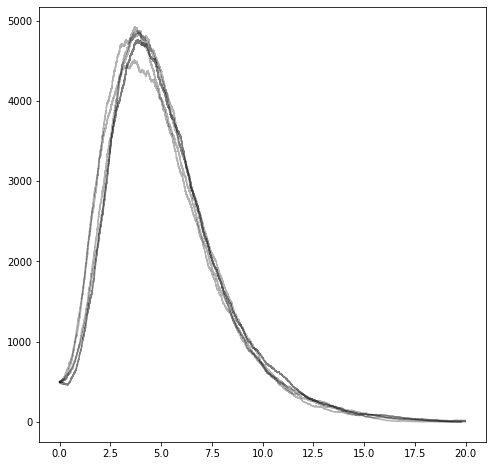

In [60]:
fig, ax = plt.subplots(figsize=(8, 8))
for counter in range(iterations): #run simulations
    t, S, I, R = EoN.fast_SIR(G, tau, gamma, rho=rho, tmax = tmax)
    if counter == 0:
        ax.plot(t, I, color = 'k', alpha=0.3, label='No Quarantine')
    ax.plot(t, I, color = 'k', alpha=0.3)
    
sum_ranges = [quarantine_cycle(G, tau, gamma, rho, _, 25) for _ in range(1, 6)]

/home/matt/config/py3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


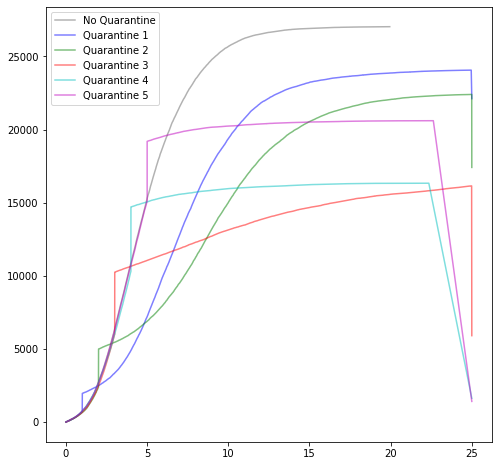

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(t, R, c='k', alpha=0.3, label='No Quarantine')
for i, el in enumerate(sum_ranges):
    ax.plot(el[0], el[3], c=c(i), alpha=0.5, label='Quarantine %s' % (i + 1))

plt.legend()
plt.show()

In [61]:
# Conjecture: on BA graphs, with this epidemic, we minimize total #R by quarantining at highest peak 
# To test this: build a function that:
# 1) Runs vanilla (no quarantine) runs multiple times to guess where the peak occurs 
# 2) Runs a sweep over single-quarantine times and shows that the peak-time is best for quarantining 
# 3) Plot {I vs T}, {R vs T} for these runs


In [62]:
# Step 1: Run vanilla quarantine multiple times to consider when peak_i is 
max_i_time = get_peak_i(G, tau, gamma, rho, tmax)[1]




In [63]:
# Step 2: run sweep:
qtimes = [max_i_time + _ for _ in range(-3, 3)]

q_cycles = [quarantine_cycle(G, tau, gamma, rho, _, tmax) for _ in qtimes]


running qs on series [0.8885731808725317, 19.11142681912747]
running qs on series [1.8885731808725317, 18.11142681912747]
running qs on series [2.8885731808725317, 17.11142681912747]
running qs on series [3.8885731808725317, 16.11142681912747]
running qs on series [4.888573180872532, 15.111426819127468]
running qs on series [5.888573180872532, 14.111426819127468]


/home/matt/config/py3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


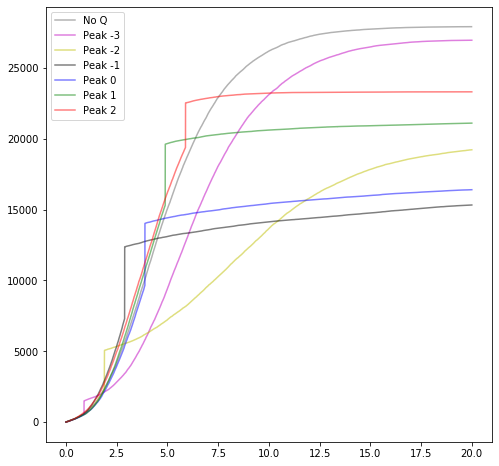

In [73]:
# Plot R vs Time
no_q = EoN.fast_SIR(G, tau, gamma, rho=rho, tmax=tmax)
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(no_q[0], no_q[3], c='k', alpha=0.3, label='No Q')
for label, sumrange in zip(range(-3, 3), q_cycles):
    ax.plot(sumrange[0], sumrange[3], c=c(label), alpha=0.5, label="Peak %s" % label)
ax.legend()

/home/matt/config/py3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


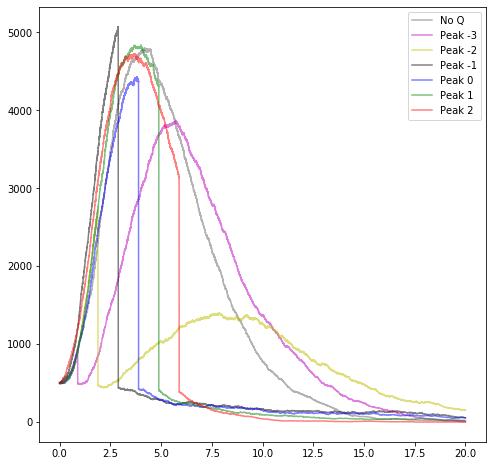

In [74]:
# Plot I vs T
# Plot R vs Time
no_q = EoN.fast_SIR(G, tau, gamma, rho=rho, tmax=tmax)
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(no_q[0], no_q[2], c='k', alpha=0.3, label='No Q')
for label, sumrange in zip(range(-3, 3), q_cycles):
    ax.plot(sumrange[0], sumrange[2], c=c(label), alpha=0.5, label="Peak %s" % label)
ax.legend()

In [ ]:
# Result: Single-quarantine-best behavior is to quarantine slightly before peak


In [ ]:
# Experiment 2: Plotting {max-I, final-R} vs. QTime 
# Step 1: Run qcycle for a sweep of data 
# Step 2: Process data and plot 

In [77]:
# Step 1:
q_range = [0.5 * _ for _ in range(0, 21)]
sums = [quarantine_cycle(G, tau, gamma, rho, _, tmax) for _ in q_range]

running qs on series [0.0, 20.0]
running qs on series [0.5, 19.5]
running qs on series [1.0, 19.0]
running qs on series [1.5, 18.5]
running qs on series [2.0, 18.0]
running qs on series [2.5, 17.5]
running qs on series [3.0, 17.0]
running qs on series [3.5, 16.5]
running qs on series [4.0, 16.0]
running qs on series [4.5, 15.5]
running qs on series [5.0, 15.0]
running qs on series [5.5, 14.5]
running qs on series [6.0, 14.0]
running qs on series [6.5, 13.5]
running qs on series [7.0, 13.0]
running qs on series [7.5, 12.5]
running qs on series [8.0, 12.0]
running qs on series [8.5, 11.5]
running qs on series [9.0, 11.0]
running qs on series [9.5, 10.5]
running qs on series [10.0, 10.0]


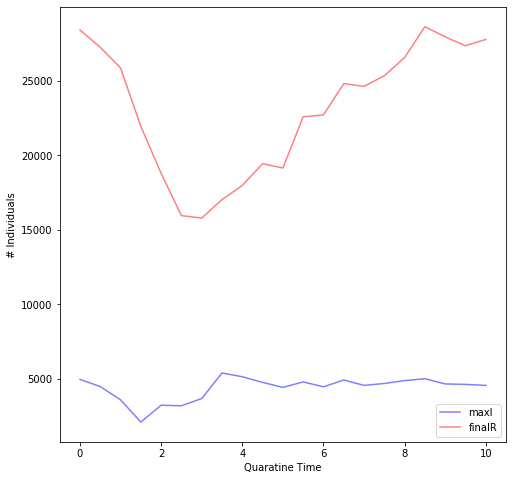

In [90]:
triples = [(qtime, get_max_I(sums[i]), get_final_R(sums[i])) for (i, qtime) in enumerate(q_range)]
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(tuple_filter(triples, 0), tuple_filter(triples, 1), c='b', alpha=0.5, label='maxI')
ax.plot(tuple_filter(triples, 0), tuple_filter(triples, 2), c='r', alpha=0.5, label='finalR')
ax.set_xlabel("Quaratine Time")
ax.set_ylabel("# Individuals")
ax.legend()

In [ ]:
plot_single_qs([0.0, 1.0, 5.0, 10.0], G, tau, gamma, rho, 25)

In [ ]:
plot_sir_counts(new_G_sum[1])

In [ ]:
plot_single_qs(range(10), G, tau, gamma, rho, 25)

In [ ]:
# build list of single-quarantine runs 
qrange = [[_ * 0.2] for _ in range(40)]
sum_ranges = [quarantine_cycle(G, tau, gamma, rho, _, 25) for _ in qrange]

In [ ]:
# Plot the max # of infected nodes vs the time at quarantine 
max_is = [get_max_I(_) for _ in sum_ranges]
final_rs = [get_final_R(_) for _ in sum_ranges]
qrange_floats = [_[0] for _ in qrange]
plt.plot(qrange_floats, max_is, c='b', label='maxInfected')
plt.plot(qrange_floats, final_rs, c='r', label='finalR')

In [ ]:


#step2, triples we care about (quarantine_time, maxI, finalR)
triples = [(qrange[i], get_max_I(_), get_final_R(_)) for i,_ in enumerate(sum_ranges)]

# step 3, plot both series
plt.plot(tuple_filter(triples, 0), tuple_filter(triples, 1), c='b', alpha=0.5, label='maxI')
plt.plot(tuple_filter(triples, 0), tuple_filter(triples, 2), c='r', alpha=0.5, label='finalR')


In [ ]:
quarantine_cycle(G, tau, gamma, rho, [5.0], )

In [ ]:
for i, el in enumerate(i_series):
    print(i, el[1][-1])


In [ ]:
for i, s in enumerate(i_series[-10:-5]): #selector(i_series):
    plt.plot(s[0], s[1], color=c(i), alpha=1.)

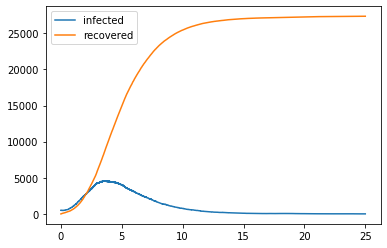

In [8]:
G3, run3 = run_until_time(G, tau, gamma, rho=rho, tmax=25.0, copy_graph=True)
plot_sir_counts(run3, ['I','R'])

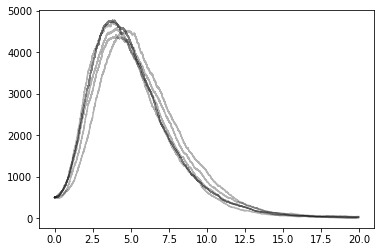

In [3]:
for counter in range(iterations): #run simulations
    t, S, I, R = EoN.fast_SIR(G, tau, gamma, rho=rho, tmax = tmax)
    if counter == 0:
        plt.plot(t, I, color = 'k', alpha=0.3, label='Simulation')
    plt.plot(t, I, color = 'k', alpha=0.3)
    

In [ ]:
t, S, I, R = EoN.fast_SIR(G, tau, gamma, rho=rho, tmax=10.0)

In [ ]:
I

In [ ]:
for counter in range(iterations): #run simulations
    t, S, I, R = EoN.fast_SIR(G, tau, gamma, rho=rho, tmax = tmax)
    if counter == 0:
        plt.plot(t, I, color = 'k', alpha=0.3, label='Simulation')
    plt.plot(t, I, color = 'k', alpha=0.3)
    
#we expect a homogeneous model to perform poorly because the degree
#distribution is very heterogeneous
t, S, I, R = EoN.SIR_homogeneous_pairwise_from_graph(G, tau, gamma, rho=rho, tmax = tmax)
plt.plot(t, I, '-.', label = 'Homogeneous pairwise', linewidth = 5)


#meanfield models will generally overestimate SIR growth because they
#treat partnerships as constantly changing.
t, S, I, R = EoN.SIR_heterogeneous_meanfield_from_graph(G, tau, gamma, rho=rho, tmax=tmax)
plt.plot(t, I, ':', label = 'Heterogeneous meanfield', linewidth = 5)

#The EBCM model does not account for degree correlations or clustering
t, S, I, R = EoN.EBCM_from_graph(G, tau, gamma, rho=rho, tmax = tmax)
plt.plot(t, I, '--', label = 'EBCM approximation', linewidth = 5)

#the preferential mixing model captures degree correlations.
t, S, I, R = EoN.EBCM_pref_mix_from_graph(G, tau, gamma, rho=rho, tmax=tmax)
plt.plot(t, I, label = 'Pref mix EBCM', linewidth=5, dashes=[4, 2, 1, 2, 1, 2])

plt.xlabel('$t$')
plt.ylabel('Number infected')

plt.legend()
plt.savefig('SIR_BA_model_vs_sim.png')

In [ ]:
#we expect a homogeneous model to perform poorly because the degree
#distribution is very heterogeneous
t, S, I, R = EoN.SIR_homogeneous_pairwise_from_graph(G, tau, gamma, rho=rho, tmax = tmax)
plt.plot(t, I, '-.', label = 'Homogeneous pairwise', linewidth = 5)


In [ ]:
#meanfield models will generally overestimate SIR growth because they
#treat partnerships as constantly changing.
t, S, I, R = EoN.SIR_heterogeneous_meanfield_from_graph(G, tau, gamma, rho=rho, tmax=tmax)
plt.plot(t, I, ':', label = 'Heterogeneous meanfield', linewidth = 5)

In [ ]:
#The EBCM model does not account for degree correlations or clustering
t, S, I, R = EoN.EBCM_from_graph(G, tau, gamma, rho=rho, tmax = tmax)
plt.plot(t, I, '--', label = 'EBCM approximation', linewidth = 5)

In [ ]:
#the preferential mixing model captures degree correlations.
t, S, I, R = EoN.EBCM_pref_mix_from_graph(G, tau, gamma, rho=rho, tmax=tmax)
plt.plot(t, I, label = 'Pref mix EBCM', linewidth=5, dashes=[4, 2, 1, 2, 1, 2])

In [ ]:
plt.xlabel('$t$')
plt.ylabel('Number infected')

plt.legend()
plt.savefig('SIR_BA_model_vs_sim.png')

In [ ]:
np.concatenate([np.array([1,2,3]), np.array([4,5, 6])])

In [ ]:
isinstance(1, (float, int))

In [ ]:
"""
    summary = EoN.fast_SIR(G, xmission, recovery, rho=rho, tmax=tmax, return_full_data=True)
    setattr(summary, 'tmax', tmax)
    # Now collect only the infected/recovered nodes 
    status_dict = _split_summary(summary)
    if copy_graph: 
        G = G.copy()
        
    G.remove_nodes_from(status_dict.get('I', []))
    G.remove_nodes_from(status_dict.get('R', []))
    
    return G, summary
"""
def plot_sir_counts(summary_list, plot_series=None):
    t, s, i, r = _cat_summaries(summary_list)
    plot_series = plot_series or ['S', 'I', 'R']
    plot_reader = {'S': (s, 'susceptible'),
                   'I': (i, 'infected'), 
                   'R': (r, 'recovered')}
    for series in plot_series:
        data, label = plot_reader[series]
        plt.plot(t, data, label=label)
    plt.legend()


In [ ]:
summary = EoN.fast_SIR(G, tau, gamma, rho=rho, tmax=25, return_full_data=True)
summary.t()

In [ ]:
t, S, I, R = EoN.fast_SIR(G, tau, gamma, rho=rho, tmax = tmax)
plt.plot(t, I)
plt.plot(summary.t(), summary.I())